In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as Keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_path = "data"

config = {
    "batch_size": 64,
    "image_size": 256,
    "n_channels": 3,
    "shuffle": True
}

In [3]:
dataset = Keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(config["image_size"], config["image_size"]),
    batch_size=config["batch_size"],
    shuffle=config["shuffle"],
)

Found 20638 files belonging to 15 classes.


In [4]:
# size of dataset = num_files(20638) / batch_size(32) = 645 
len(dataset)

323

In [5]:
class_names = dataset.class_names

In [19]:
train_config = {
    "epochs": 10,
    "fine_tuning_epochs": 2,
    "train_split": 0.8,
    "test_split": 0.1,
    "shuffle": True,
    "early_stopping_patience": 3,
    "lr_sch_round": 6
}

In [7]:
def split_dataset(dataset, train_split, test_split, shuffle=False, shuffle_size=10000):
    ds_len = len(dataset)
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=10)
    
    train_size = int(ds_len * train_split)
    test_size = int(ds_len * test_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = split_dataset(
    dataset, 
    train_config["train_split"],
    train_config["test_split"], 
    shuffle=train_config["shuffle"]
)

print(f"...Train set: {len(train_ds)}")
print(f"...Val set: {len(val_ds)}")
print(f"...Test set: {len(test_ds)}")

...Train set: 258
...Val set: 33
...Test set: 32


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
INPUT_SHAPE = (config["batch_size"], config["image_size"], config["image_size"], config["n_channels"])
N_CLASSES = len(class_names)

In [11]:
Resize_rescale = Keras.Sequential([
    Keras.layers.Resizing(INPUT_SHAPE[1], INPUT_SHAPE[2]),
    Keras.layers.Rescaling(scale=1./255),
])

In [12]:
Augmentation = Keras.Sequential([
    Keras.layers.RandomFlip(),
    Keras.layers.RandomRotation(factor=0.2),
])

In [13]:
base_model = Keras.applications.resnet.ResNet50(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE[1:])
base_model.trainable = False

inputs = Keras.layers.Input(shape=INPUT_SHAPE[1:])

x = base_model(inputs, training=False)

x = Keras.layers.GlobalAveragePooling2D()(x)

x = Keras.layers.Dense(256, activation="relu")(x)

x = Keras.layers.Dense(256, activation="relu")(x)

outputs = Keras.layers.Dense(N_CLASSES, activation="softmax")(x)

model = Keras.Model(inputs, outputs)

In [14]:
model.build(input_shape=INPUT_SHAPE)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 15)                3855      
                                                             

In [16]:
model.compile(
    optimizer=Keras.optimizers.Adam(learning_rate=1e-3),
    loss=Keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [17]:
callbacks = []

early_stopping = Keras.callbacks.EarlyStopping(monitor="val_loss", patience=train_config["early_stopping_patience"])
callbacks.append(early_stopping)

def lr_sch(epoch, lr):
    if epoch < train_config["lr_sch_round"] :
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = Keras.callbacks.LearningRateScheduler(lr_sch)
callbacks.append(lr_scheduler)

In [18]:
tf.get_logger().setLevel('ERROR')
history = model.fit(
    train_ds, 
    batch_size=config["batch_size"], 
    epochs=train_config["epochs"], 
    validation_data=val_ds, 
    callbacks=callbacks
).history

Epoch 1/10
258/258 [==============================] - 149s 431ms/step - loss: 0.4454 - accuracy: 0.8602 - val_loss: 0.2481 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 2/10
258/258 [==============================] - 92s 358ms/step - loss: 0.1699 - accuracy: 0.9442 - val_loss: 0.1060 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 3/10
258/258 [==============================] - 80s 309ms/step - loss: 0.1103 - accuracy: 0.9641 - val_loss: 0.1161 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/10
258/258 [==============================] - 77s 297ms/step - loss: 0.0804 - accuracy: 0.9731 - val_loss: 0.0696 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/10
258/258 [==============================] - 85s 330ms/step - loss: 0.0633 - accuracy: 0.9782 - val_loss: 0.0793 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 6/10
258/258 [==============================] - 89s 344ms/step - loss: 0.0489 - accuracy: 0.9843 - val_loss: 0.0504 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/10
258/258 [==============================]

In [20]:
# fine tuning
base_model.trainable = True

model.compile(
    optimizer=Keras.optimizers.Adam(learning_rate=1e-7),
    loss=Keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.fit(
    train_ds, 
    batch_size=config["batch_size"], 
    epochs=train_config["fine_tuning_epochs"], 
    validation_data=val_ds, 
)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model/resnet50/conv2_block3_3_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Rajat\AppData\Local\Temp\ipykernel_15284\2664526122.py", line 10, in <cell line: 10>
      model.fit(
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\Rajat\anaconda3\envs\ml-tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/resnet50/conv2_block3_3_conv/Conv2D'
OOM when allocating tensor with shape[64,64,64,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/resnet50/conv2_block3_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_33096]

Text(0.5, 1.0, 'Training Validation Loss')

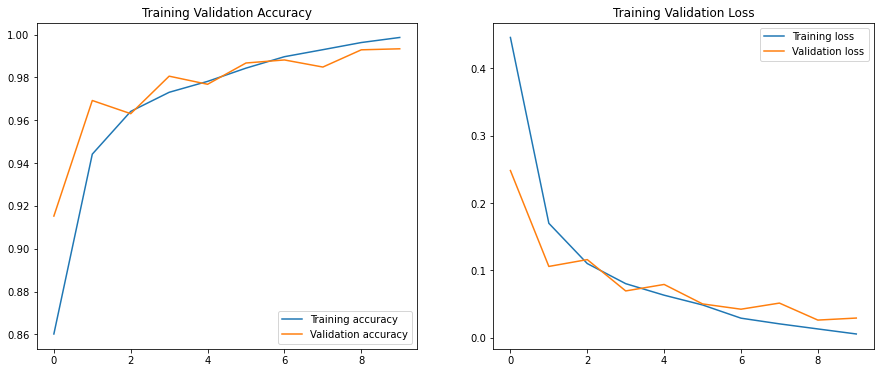

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history["accuracy"])), history["accuracy"], label="Training accuracy")
plt.plot(range(len(history["val_accuracy"])), history["val_accuracy"], label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(len(history["loss"])), history["loss"], label="Training loss")
plt.plot(range(len(history["val_loss"])), history["val_loss"], label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training Validation Loss")

In [22]:
score = model.evaluate(test_ds)

score

32/32 [==============================] - 35s 203ms/step - loss: 0.0234 - accuracy: 0.9932


[0.023417871445417404, 0.9931640625]

In [23]:
def predict(model, image, class_names=None):
    image_arr = Keras.preprocessing.image.img_to_array(image)
    image_batch = tf.expand_dims(image_arr, 0)
    predictions = model.predict(image_batch)
    predicted_output = tf.argmax(predictions[0])
    if class_names is not None:
        predicted_output = class_names[tf.argmax(predictions[0])]
    confidence_score = round(100 * predictions[0][predicted_output], 2)
    return predicted_output, confidence_score

In [24]:
def show_predictions(dataset, model, batch_num, n_images, class_names):
    for image_batch, label_batch in dataset.take(batch_num):
        for i in range(n_images):
            plt.subplot(int(n_images/3), 3, i + 1)
            pred, confi = predict(model, image_batch[i].numpy())
            if type(pred) == "string":
                pred_class = pred
            else:
                pred_class = class_names[pred]
            actual_class = class_names[label_batch[i].numpy()]
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(f"Actual: {actual_class} \n Predicted: {pred_class} \n Confidence: {confi}%")
            plt.axis("off")

1/1 [==============================] - 0s 38ms/step


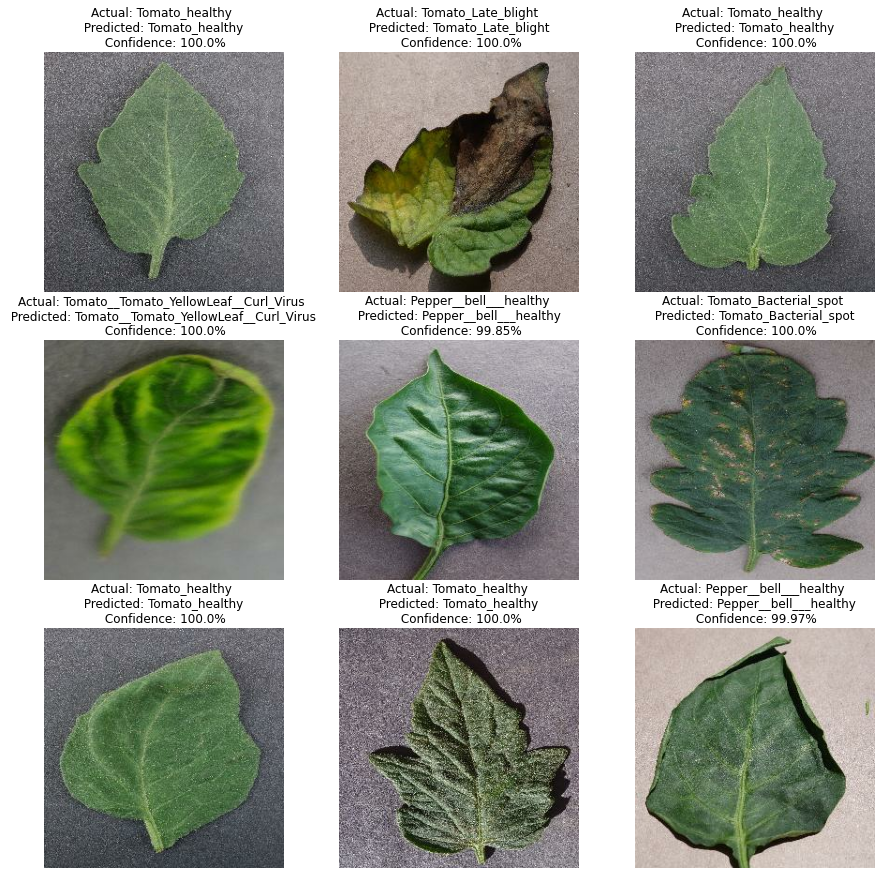

In [27]:
plt.figure(figsize=(15, 15))
show_predictions(test_ds, model, batch_num=1, n_images=9, class_names=class_names)

In [26]:
model_version = max([int(i) for i in os.listdir("models")]) + 1
model.save(f"models/{model_version}")